
=== Thuật toán: First Fit ===
Buffer 0: Avg Utilization = 64.63%, Avg Buffered = 0.00
Buffer 2: Avg Utilization = 68.82%, Avg Buffered = 2.00
Buffer 4: Avg Utilization = 73.24%, Avg Buffered = 3.76
Buffer 6: Avg Utilization = 74.78%, Avg Buffered = 4.74

=== Thuật toán: Best Fit ===
Buffer 0: Avg Utilization = 3.83%, Avg Buffered = 0.00
Buffer 2: Avg Utilization = 69.62%, Avg Buffered = 2.00
Buffer 4: Avg Utilization = 72.22%, Avg Buffered = 3.84
Buffer 6: Avg Utilization = 73.31%, Avg Buffered = 5.13

=== Thuật toán: Bottom-Left-Back ===
Buffer 0: Avg Utilization = 3.83%, Avg Buffered = 0.00
Buffer 2: Avg Utilization = 75.40%, Avg Buffered = 1.99
Buffer 4: Avg Utilization = 79.24%, Avg Buffered = 3.43
Buffer 6: Avg Utilization = 79.99%, Avg Buffered = 3.95


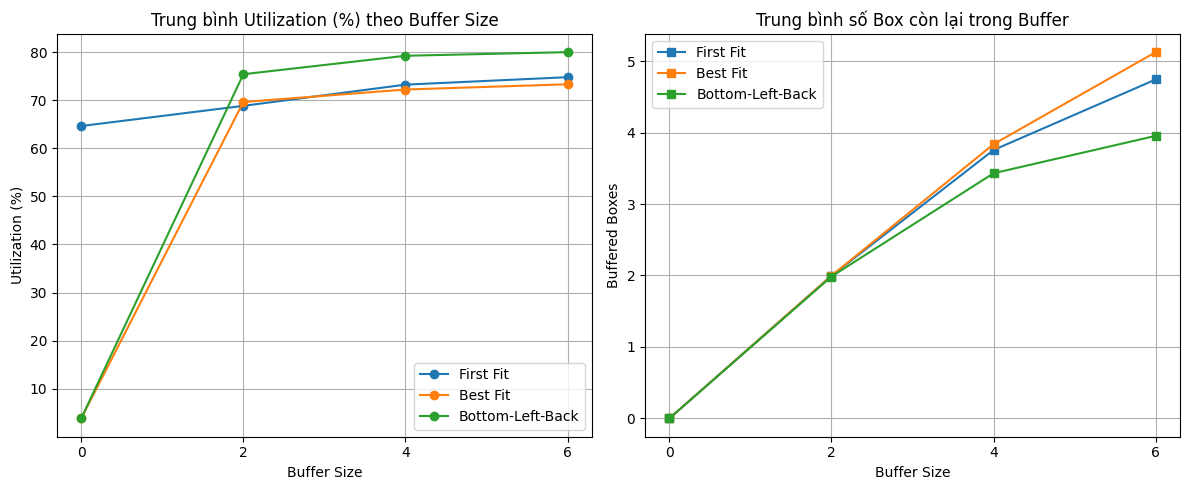

In [1]:
import os
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.core.box import Box
from src.heuristics.first_fit import FirstFitBufferPacker
from src.heuristics.best_fit import BestFitBufferPacker
from src.heuristics.bottom_left_back import BottomLeftBackBufferPacker


def load_data_from_pt(file_path):
    """Tải dữ liệu từ file .pt, mỗi phần tử là 1 bộ box."""
    return torch.load(file_path, map_location=torch.device('cpu'))


def run_buffer_algorithms_on_dataset(data, algorithms, buffer_sizes, bin_size):
    """Chạy các thuật toán buffer trên toàn bộ dataset, trả về kết quả trung bình."""
    results_util = {alg: [] for alg in algorithms}
    results_buffer = {alg: [] for alg in algorithms}

    total_instances = len(data)

    for alg_name, PackerClass in algorithms.items():
        print(f"\n=== Thuật toán: {alg_name} ===")
        for buffer_size in buffer_sizes:
            util_list = []
            buffer_list = []

            for box_dims_list in data:
                boxes = [Box(*dims) for dims in box_dims_list]
                packer = PackerClass(
                    binsize=tuple(bin_size),
                    buffer_size=buffer_size,
                    boxes=copy.deepcopy(boxes)
                )
                packer.pack_all_boxes()
                util_list.append(packer.utilization() * 100)  # %
                buffer_list.append(len(packer.get_buffered_boxes()))

            # Trung bình sau toàn bộ dữ liệu
            avg_util = np.mean(util_list)
            avg_buffer = np.mean(buffer_list)

            results_util[alg_name].append(avg_util)
            results_buffer[alg_name].append(avg_buffer)

            print(f"Buffer {buffer_size}: Avg Utilization = {avg_util:.2f}%, "
                  f"Avg Buffered = {avg_buffer:.2f}")

    return results_util, results_buffer


def plot_results(buffer_sizes, results_util, results_buffer):
    """Vẽ biểu đồ kết quả trung bình trên tập dữ liệu."""
    plt.figure(figsize=(12, 5))

    # Utilization plot
    plt.subplot(1, 2, 1)
    for alg_name in results_util:
        plt.plot(buffer_sizes, results_util[alg_name], marker='o', label=alg_name)
    plt.title("Trung bình Utilization (%) theo Buffer Size")
    plt.xlabel("Buffer Size")
    plt.ylabel("Utilization (%)")
    plt.xticks(buffer_sizes)
    plt.grid(True)
    plt.legend()

    # Buffered boxes plot
    plt.subplot(1, 2, 2)
    for alg_name in results_buffer:
        plt.plot(buffer_sizes, results_buffer[alg_name], marker='s', label=alg_name)
    plt.title("Trung bình số Box còn lại trong Buffer")
    plt.xlabel("Buffer Size")
    plt.ylabel("Buffered Boxes")
    plt.xticks(buffer_sizes)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



pt_file = os.path.join("..", "data", "cut_1.pt")
data = load_data_from_pt(pt_file)

buffer_sizes = [0, 2, 4, 6]
bin_size = [10, 10, 10]

algorithms = {
    "First Fit": FirstFitBufferPacker,
    "Best Fit": BestFitBufferPacker,
    "Bottom-Left-Back": BottomLeftBackBufferPacker
}

results_util, results_buffer = run_buffer_algorithms_on_dataset(
    data, algorithms, buffer_sizes, bin_size
)

plot_results(buffer_sizes, results_util, results_buffer)
